In [1]:
import os
os.environ ["TAVILY_API_KEY"] = "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"

In [1]:
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

pdf_files = [
"/nfs/turbo/si-acastel/expert_field_project/full_pdfs_by_author/huesmann/978-1-4757-4648-8_5.pdf",
"/nfs/turbo/si-acastel/expert_field_project/full_pdfs_by_author/huesmann/jclp22313_am.pdf",
"/nfs/turbo/si-acastel/expert_field_project/full_pdfs_by_author/huesmann/s15327965pli0803_7.pdf"
]
# Function to load and process each PDF
def load_pdfs(pdf_list):
    documents = []  # To store the loaded document objects
    for pdf_path in pdf_list:
        # Initialize the loader for the current PDF
        loader = PyMuPDFLoader(file_path=pdf_path)
        # Load the data from the PDF
        docs = loader.load()
        documents.extend(docs)  # Append loaded documents to the list
    return documents

# Process the PDF files
all_documents = load_pdfs(pdf_files)

# Print out the content of each document
for doc in all_documents:
    print(f"Document Metadata: {doc.metadata}")
    print(f"Document Content:\n{doc.page_content}")
    print("-" * 40)

Document Metadata: {'source': '/nfs/turbo/si-acastel/expert_field_project/full_pdfs_by_author/huesmann/978-1-4757-4648-8_5.pdf', 'file_path': '/nfs/turbo/si-acastel/expert_field_project/full_pdfs_by_author/huesmann/978-1-4757-4648-8_5.pdf', 'page': 0, 'total_pages': 20, 'format': 'PDF 1.4', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'Adobe Acrobat 9.4 Paper Capture Plug-in', 'creationDate': "D:20131227204008+08'00'", 'modDate': "D:20131227205059+08'00'", 'trapped': ''}
Document Content:
OBSERVATIONAL LEARNING OF VIOLENT 
BEHAVIOR 
Social and Biosocial Processes 
L. Rowell Huesmann 
Research Center for Group Dynamics 
Institute for Social Research 
University of Michigan 
Ann Arbor, Michigan 48106-1248 
1. INTRODUCTION 
5 
Although habitual aggressive and violent behaviors seldom develop in children un-
less there is a convergence of multiple predisposing and precipitating biosocial and con-
textual factors, there is compelling evidence that ear

In [3]:
# Initialize a text splitter with specified chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
# Split the documents into chunks
doc_splits = text_splitter.split_documents(all_documents)
print(doc_splits)

[Document(metadata={'source': '/nfs/turbo/si-acastel/expert_field_project/full_pdfs_by_author/huesmann/978-1-4757-4648-8_5.pdf', 'file_path': '/nfs/turbo/si-acastel/expert_field_project/full_pdfs_by_author/huesmann/978-1-4757-4648-8_5.pdf', 'page': 0, 'total_pages': 20, 'format': 'PDF 1.4', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'Adobe Acrobat 9.4 Paper Capture Plug-in', 'creationDate': "D:20131227204008+08'00'", 'modDate': "D:20131227205059+08'00'", 'trapped': ''}, page_content="OBSERVATIONAL LEARNING OF VIOLENT \nBEHAVIOR \nSocial and Biosocial Processes \nL. Rowell Huesmann \nResearch Center for Group Dynamics \nInstitute for Social Research \nUniversity of Michigan \nAnn Arbor, Michigan 48106-1248 \n1. INTRODUCTION \n5 \nAlthough habitual aggressive and violent behaviors seldom develop in children un-\nless there is a convergence of multiple predisposing and precipitating biosocial and con-\ntextual factors, there is compelling evidence

In [5]:
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_huggingface.embeddings import HuggingFaceEmbeddings


#TODO: not a priority but try a local embedding again
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
)
retriever = vectorstore.as_retriever(k=4)

RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [6]:
import socket, os, subprocess

# Get random port
s = socket.socket()
s.bind(('', 0))
port = s.getsockname()[1]
s.close()

# Set environment variables
os.environ['OLPORT'] = str(port)
os.environ['OLLAMA_HOST'] = f'127.0.0.1:{port}'
os.environ['OLLAMA_BASE_URL'] = f'http://localhost:{port}'

ollama_path = os.path.expanduser('~/ollama/bin/ollama')
subprocess.Popen([ollama_path, 'serve'], 
                stdout=open(f'ollama_{port}.log', 'w'),
                stderr=open(f'ollama_{port}.err', 'w'))

print(f"Ollama started on port {port}")

Ollama started on port 40465


In [6]:
from langchain.schema import Document
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults()

In [7]:
from langchain_ollama import ChatOllama 
from langchain.prompts import PromptTemplate 
from langchain_core.output_parsers import StrOutputParser

ollama_base_url = f"http://localhost:{port}"
prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks about researchers at the univeristy of michigan.
    Use the following documents to answer the question.
    If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise:
    Question: {question}
    Documents: {documents}
    Answer:
    """,
    input_variables=["question", "documents"],
)
llm = ChatOllama(
model="llama3.1", temperature=0, base_url=ollama_base_url
)
rag_chain = prompt | llm | StrOutputParser()

In [8]:
from langchain_core.prompts import ChatPromptTemplate 
from langchain_core.output_parsers import JsonOutputParser

# JSON
llm = ChatOllama(model="llama3.1", format="json" , temperature=0,  base_url=ollama_base_url)

prompt = PromptTemplate(
template="""You are a grader assessing relevance of a retrieved document 
            to a user question. \nHere.
            is the retrieved document: \n\n {document} \n\n
            Here is the user question: {question} \n
            If the document contains keywords related to the user question grade it as relevant.  
            It does not need to be a stringent test. 
            The goal is to filter out erroneous retrievals. \n
            Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n 
            Provide the binary score as a JSON with a single key 'score' and no premable or explanation.""",
            input_variables=["question", "document"],
)
retrieval_grader = prompt | llm | JsonOutputParser ()

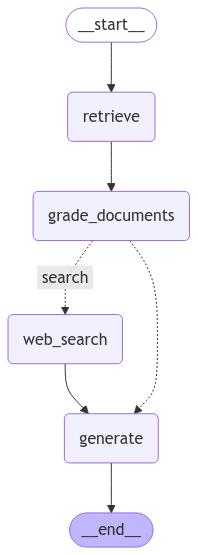

In [9]:
from typing_extensions import TypedDict, List 
from IPython.display import Image, display 
from langgraph.graph import START, END, StateGraph

class GraphState(TypedDict):
    """AssertionError
            Represents the state of our graph.
            Attributes:
            question: question generation: LL generation search: whether to add search documents: list of documents
            question: str generation: str search: str
            documents: List (str]
    """
    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]

def retrieve(state):
    """
    Retrieve documents
    Args:
    state (dict): The current graph state
    Returns:
    state (dict): New key added to state, documents, that contains retrieved
    """
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}

def generate(state):
    """Generate answer
    Args:
    state (dict): The current graph state
    Returns:
    state (dict): New key added to state, generation, that contains LUM generation"""

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append ("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }

def grade_documents(state):
    """
    Args:
    state (dict): The current graph state
    Returns:
    state (dict): Updates documents key with only filtered relevant documents
    """
    question = state["question" ]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"  
            continue
    return{
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }

def web_search(state):
    """
    Web search based on the re-phrased question.
    Args:
    state (dict): The current graph state
    Returns:
    state (dict): Updates documents key with appended web results
    """
    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]}) 
            for d in web_results
        ]
    )
    return {"documents": documents, "question": question, "steps": steps}

def decide_to_generate(state):
    """Determines whether to generate an answer, or re-generate a question.
    Args:
    state (dict): The current graph state
    Returns:
    str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search" 
    else:
        return "generate"

def classify_question(state):
    """Classify if question requires doc summary vs specific answer"""
    question = state["question"]
    documents = state["documents"]  # Need documents from retrieve step
    classifier = pipeline("text-classification", model="cnmoro/bert-tiny-question-classifier")
    result = classifier(question)
    question_type = result[0]['label']
    steps = state["steps"]
    steps.append("classify_question")
    return {
        "question": question,
        "question_type": question_type,
        "documents": documents,  # Pass documents through
        "steps": steps
    }

def decide_path(state):
    """Route to summary or regular RAG flow"""
    return "summarize" if state["question_type"] == "LABEL_1" else "grade_documents" 

def generate_summary(state):
    """Summarize documents"""
    documents = state["documents"]
    steps = state["steps"]
    steps.append("generate_summary")

    # Combine doc contents
    combined_text = "\n".join([doc.page_content for doc in documents])
    
    prompt = ChatPromptTemplate.from_template("""
    Summarize the following text:
    {text}
    """)

    summary_chain = prompt | ChatOllama(model="llama3.1", base_url=ollama_base_url)
    summary = summary_chain.invoke({"text": combined_text})

    return {
        "documents": documents,
        "question": state["question"], 
        "generation": summary.content,
        "steps": steps
    }

# Graph
workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("retrieve", retrieve) 
workflow.add_node("grade_documents", grade_documents) # grade documents 
workflow.add_node("generate", generate) # generatae 
workflow.add_node("web_search", web_search) # web search
# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents") 
workflow.add_conditional_edges(
    "grade_documents", 
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)
custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

In [11]:
# import uuid

def predict_custom_agent_answer(example: dict):
    # config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    state_dict = custom_graph.invoke({"question": example["input"], "steps": []})
    return {"response": state_dict["generation"], "steps": state_dict["steps"]} 

example = {"input": "Do habitual aggressive behaviors develop in children"}
response = predict_custom_agent_answer(example)
response

{'response': 'Yes, habitual aggressive behaviors develop in children. Early learning and socialization play a key role in this development, with aggression emerging early in life and being predictive of later aggressive behavior. Children who grow up in environments that reinforce aggression are more likely to develop habitual aggressive behaviors.',
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'generate_answer']}

In [12]:
# import uuid

def predict_custom_agent_answer(example: dict):
    # config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    state_dict = custom_graph.invoke({"question": example["input"], "steps": []})
    return {"response": state_dict["generation"], "steps": state_dict["steps"]} 

example = {"input": "where can I contact Rowell Huesmann"}
response = predict_custom_agent_answer(example)
response

{'response': 'You can contact Rowell Huesmann at huesmann@umich.edu or through the Institute for Social Research, The University of Michigan, 426 Thompson St., Ann Arbor, MI 48106-1248, USA. He is also available by phone at (949) 673-0767 during the day and evening.',
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'web_search',
  'generate_answer']}

## example with regular prompt

In [16]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama
from langchain_core.runnables import RunnablePassthrough

ollama_base_url = f"http://localhost:{port}"

prompt = ChatPromptTemplate.from_template("""
Answer the question based only on the following context. If you cannot answer the question based on the context, say "I cannot answer this based on the provided context."

Context: {context}
Question: {question}

Answer: """)

# 6. Create chain
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | ChatOllama(model="llama3.1", base_url=ollama_base_url)
)

# 7. Interactive question-answering loop
print("RAG System Ready! Ask questions about your documents (type 'quit' to exit)")
print("-" * 50)

while True:
    question = input("\nYour question: ")
    if question.lower() in ['quit', 'exit', 'q']:
        print("Goodbye!")
        break
    
    try:
        response = chain.invoke(question)
        print("\nAnswer:", response)
        print("-" * 40)  # Separator line
    except Exception as e:
        print(f"\nAn error occurred: {str(e)}")

RAG System Ready! Ask questions about your documents (type 'quit' to exit)
--------------------------------------------------

Answer: content='I cannot summarize these documents as I do not have the context to do so. However, I can suggest a possible approach to summarizing them.\n\nTo summarize the documents, I would first need to understand the content of each document and identify any common themes or keywords. Based on the provided metadata, it appears that the documents are related to computer-aided analysis of basaltic rocks from Costa Rica using INAA (Instrumental Neutron Activation Analysis) measurements. However, without access to the actual content of the documents, I cannot provide a summary.\n\nIf you would like me to try and summarize the documents based on the provided metadata alone, please let me know.' additional_kwargs={} response_metadata={'model': 'llama3.1', 'created_at': '2024-12-07T22:20:34.889265556Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reas

KeyboardInterrupt: Interrupted by user

In [43]:
# import uuid

def predict_custom_agent_answer(example: dict):
    # config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    state_dict = custom_graph.invoke({"question": example["input"], "steps": []})
    return {"response": state_dict["generation"], "steps": state_dict["steps"]} 

example = {"input": "can you tell me about basaltic rocks"}
response = predict_custom_agent_answer(example)
response

{'response': "Basaltic rocks are a type of igneous rock that is rich in iron and magnesium, with a composition similar to that of the Earth's mantle. They can be classified into different types based on their degree of magmatic differentiation, ranging from primitive basalts to highly differentiated basalts. The table in document (5) lists various basaltic rocks from different regions, including Costa Rica and the GDR, with their respective chemical compositions.",
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'generate_answer']}